In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan 
from smyleutils import regrid_utils as regrid
from smyleutils import mapplot_utils as mymaps
from smyleutils import averaging_utils as avg
from smyleutils import linfit_utils as linfit
from smyleutils import plothisto_utils as histo
from smyleutils import bootstrap_utils as boot
from smyleutils import colorbar_utils as cbars
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')
import sys

In [2]:
plotpath="/glade/campaign/cgd/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

In [3]:
def calcmsss(mod,obs,dim='init_year'):
    mse_mod = (1./mod[dim].size)*((mod - obs)**2).sum('init_year')
    mse_obs = (1./mod[dim].size)*(obs**2).sum('init_year')
    msss = 1 - (mse_mod / mse_obs)

    # dealing with the levels where low top doesn't have any data
    msss = msss.where( msss != 1, nan)
    return msss

### Read in the QBO for compositing

In [4]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_era5_nov=xr.open_dataset(basepath+'Uzm_ERA5_day_init11.nc').Uzm
uzm_era5_nov = uzm_era5_nov.sel(init_year=slice(1979,2020))
uzm_era5_nov_tr = avg.cosweightlat(uzm_era5_nov,-5,5).load()
uqbo = uzm_era5_nov_tr.interp(level=50.).sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uqbo = uqbo - uqbo.mean('init_year')
uqbo_std = uqbo.std('init_year')

DataArrayWeighted with weights along dimensions: lat


### Read in SSTs and calculate the Nino3.4 index

In [15]:
### Compute the Nino3.4 index
sst = xr.open_dataset("/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SST/SST_ERSSTv5_mon_init11.nc")
sstm =  sst.mean('time')
nino34 = avg.cosweightlonlat(sstm, 210, 270, -5, 5)
nino34 = nino34.sel(init_year=slice(1979,2020))

### Read in the precipitation data and calculate the DJF average

In [8]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/PRECIP/"
gpcp = xr.open_dataset(basepath+"PRECIP_GPCP_mon_init11.nc").precip
l83 = xr.open_dataset(basepath+'PRECT_BSMYLE-CW3E-L83_mon_init11.nc').PRECT*86400.*1000.
l32 = xr.open_dataset(basepath+'PRECT_BSMYLE-CW3E-L32_mon_init11.nc').PRECT*86400.*1000.

gpcp = gpcp.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
l83 = l83.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
l32 = l32.sel(time=slice("1970-12-01","1971-02-28")).mean('time')

gpcp = gpcp.sel(init_year=slice(1979,2020))
l83 = l83.sel(init_year=slice(1979,2020))
l32 = l32.sel(init_year=slice(1979,2020))

### Remove the lead dependent climatology

In [9]:
gpcp = gpcp - gpcp.mean('init_year')
l83 = l83 - l83.mean('M').mean('init_year')
l32 = l32 - l32.mean('M').mean('init_year')

### Regrid the model conservatively onto the GPCP grid

In [10]:
l83 = regrid.regrid_conservative(l83, l83.lon, l83.lat, gpcp.lon, gpcp.lat, reuse_wgts=False,
                                 wgtfile='/glade/derecho/scratch/islas/temp/wgt.nc')
l32 = regrid.regrid_conservative(l32, l32.lon, l32.lat, gpcp.lon, gpcp.lat, reuse_wgts=True,
                                 wgtfile='/glade/derecho/scratch/islas/temp/wgt.nc')

### Calculate the ACC and the MSSS

In [11]:
cor_l83 = xr.corr(gpcp, l83.mean('M'), dim='init_year')
cor_l32 = xr.corr(gpcp, l32.mean('M'), dim='init_year')

msss_l83 = calcmsss(l83.mean('M'), gpcp)
msss_l32 = calcmsss(l32.mean('M'), gpcp)

### Remove the ENSO influence

In [16]:
a_gpcp = xr.DataArray(np.zeros([gpcp.lat.size, gpcp.lon.size]), dims=['lat','lon'], coords=[gpcp.lat, gpcp.lon])
b_gpcp = xr.DataArray(np.zeros([gpcp.lat.size, gpcp.lon.size]), dims=['lat','lon'], coords=[gpcp.lat, gpcp.lon])

a_l83 = xr.DataArray(np.zeros([gpcp.lat.size, gpcp.lon.size]), dims=['lat','lon'], coords=[gpcp.lat, gpcp.lon])
b_l83 = xr.DataArray(np.zeros([gpcp.lat.size, gpcp.lon.size]), dims=['lat','lon'], coords=[gpcp.lat, gpcp.lon])

a_l32 = xr.DataArray(np.zeros([gpcp.lat.size, gpcp.lon.size]), dims=['lat','lon'], coords=[gpcp.lat, gpcp.lon])
b_l32 = xr.DataArray(np.zeros([gpcp.lat.size, gpcp.lon.size]), dims=['lat','lon'], coords=[gpcp.lat, gpcp.lon])

for ilat in np.arange(0,gpcp.lat.size,1):
    for ilon in np.arange(0,gpcp.lon.size,1):
        at, bt = linfit.linfit_xy(nino34.ssta, gpcp.isel(lon=ilon, lat=ilat))
        a_gpcp[ilat,ilon] = at
        b_gpcp[ilat,ilon] = bt
        
        at, bt = linfit.linfit_xy(nino34.ssta, l83.mean('M').isel(lon=ilon, lat=ilat))
        a_l83[ilat,ilon] = at
        b_l83[ilat,ilon] = bt
        
        at, bt = linfit.linfit_xy(nino34.ssta, l32.mean('M').isel(lon=ilon, lat=ilat))
        a_l32[ilat,ilon] = at
        b_l32[ilat,ilon] = bt

In [17]:
gpcp_noenso = gpcp - (a_gpcp + b_gpcp*nino34.ssta)
l83_noenso = l83 - (a_l83 + b_l83*nino34.ssta)
l32_noenso = l32 - (a_l32 + b_l32*nino34.ssta)

In [18]:
west_gpcp_noenso = gpcp_noenso.isel(init_year = uqbo.values > uqbo_std.values)
east_gpcp_noenso = gpcp_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values)

west_l83_noenso = l83_noenso.isel(init_year = uqbo.values > uqbo_std.values)
east_l83_noenso = l83_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values)

west_l32_noenso = l32_noenso.isel(init_year = uqbo.values > uqbo_std.values)
east_l32_noenso = l32_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values)

# significance of the differences between westerly and easterly
gpcp_difsignif_noenso = boot.bootdif2means(east_gpcp_noenso, west_gpcp_noenso)
l83_difsignif_noenso = boot.bootdif2means(east_l83_noenso.mean('M'), west_l83_noenso.mean('M'))
l32_difsignif_noenso = boot.bootdif2means(east_l32_noenso.mean('M'), west_l32_noenso.mean('M'))

In [21]:
### Read in the significance data for the ACC and MSSS
signifdat = xr.open_dataset("/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SIGNIF/fig14/pr_ci_initmon11_DJF.nc")

### Computing the average over the regions of highest anomalies in the observational composite

In [22]:
l83_noenso_westbox = avg.cosweightlonlat(l83_noenso, 135, 160, -22, 10)
l83_noenso_eastbox = avg.cosweightlonlat(l83_noenso, 180, 220, -22, 10)

l32_noenso_westbox = avg.cosweightlonlat(l32_noenso, 135, 160, -22, 10)
l32_noenso_eastbox = avg.cosweightlonlat(l32_noenso, 180, 220, -22, 10)

gpcp_noenso_westbox = avg.cosweightlonlat(gpcp_noenso, 135, 160, -22, 10)
gpcp_noenso_eastbox = avg.cosweightlonlat(gpcp_noenso, 180, 220, -22, 10)

### Single member bootstrap samples

In [26]:
boot_l83_westbox = [] ; boot_l83_eastbox = []
boot_l32_westbox = [] ; boot_l32_eastbox = []
for iyear in np.arange(0,l83_noenso.init_year.size,1):
    bootdat_l83 = boot.bootgen(l83_noenso_westbox.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_l83_westbox.append(bootdat_l83)
    
    bootdat_l32 = boot.bootgen(l32_noenso_westbox.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_l32_westbox.append(bootdat_l32)
    
    bootdat_l83 = boot.bootgen(l83_noenso_eastbox.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_l83_eastbox.append(bootdat_l83)
    
    bootdat_l32 = boot.bootgen(l32_noenso_eastbox.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_l32_eastbox.append(bootdat_l32)
    
boot_l83_westbox = xr.concat(boot_l83_westbox, dim=l83_noenso.init_year)
boot_l32_westbox = xr.concat(boot_l32_westbox, dim=l83_noenso.init_year)
boot_l83_eastbox = xr.concat(boot_l83_eastbox, dim=l83_noenso.init_year)
boot_l32_eastbox = xr.concat(boot_l32_eastbox, dim=l83_noenso.init_year)

### QBO composites

In [27]:
pr_west_gpcp_westbox = gpcp_noenso_westbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_gpcp_westbox = gpcp_noenso_westbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_gpcp_eastbox = gpcp_noenso_eastbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_gpcp_eastbox = gpcp_noenso_eastbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_l83_westbox = l83_noenso_westbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_l83_westbox = l83_noenso_westbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_l83_eastbox = l83_noenso_eastbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_l83_eastbox = l83_noenso_eastbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_l32_westbox = l32_noenso_westbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_l32_westbox = l32_noenso_westbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_l32_eastbox = l32_noenso_eastbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_l32_eastbox = l32_noenso_eastbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_boot_l83_westbox = boot_l83_westbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_boot_l83_westbox = boot_l83_westbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_boot_l83_eastbox = boot_l83_eastbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_boot_l83_eastbox = boot_l83_eastbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_boot_l32_westbox = boot_l32_westbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_boot_l32_westbox = boot_l32_westbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

pr_west_boot_l32_eastbox = boot_l32_eastbox.isel(init_year = uqbo.values > uqbo_std.values)
pr_east_boot_l32_eastbox = boot_l32_eastbox.isel(init_year = uqbo.values < -1.*uqbo_std.values)

In [28]:
pr_qbo_dif_gpcp_westbox = pr_east_gpcp_westbox.mean('init_year') - pr_west_gpcp_westbox.mean('init_year')
pr_qbo_dif_gpcp_eastbox = pr_east_gpcp_eastbox.mean('init_year') - pr_west_gpcp_eastbox.mean('init_year')

pr_qbo_dif_l83_westbox = pr_east_l83_westbox.mean('init_year') - pr_west_l83_westbox.mean('init_year')
pr_qbo_dif_l83_eastbox = pr_east_l83_eastbox.mean('init_year') - pr_west_l83_eastbox.mean('init_year')

pr_qbo_dif_l32_westbox = pr_east_l32_westbox.mean('init_year') - pr_west_l32_westbox.mean('init_year')
pr_qbo_dif_l32_eastbox = pr_east_l32_eastbox.mean('init_year') - pr_west_l32_eastbox.mean('init_year')

pr_qbo_dif_l83_boot_westbox = pr_east_boot_l83_westbox.mean('init_year') - pr_west_boot_l83_westbox.mean('init_year')
pr_qbo_dif_l83_boot_eastbox = pr_east_boot_l83_eastbox.mean('init_year') - pr_west_boot_l83_eastbox.mean('init_year')

pr_qbo_dif_l32_boot_westbox = pr_east_boot_l32_westbox.mean('init_year') - pr_west_boot_l32_westbox.mean('init_year')
pr_qbo_dif_l32_boot_eastbox = pr_east_boot_l32_eastbox.mean('init_year') - pr_west_boot_l32_eastbox.mean('init_year')

### plotting the plot

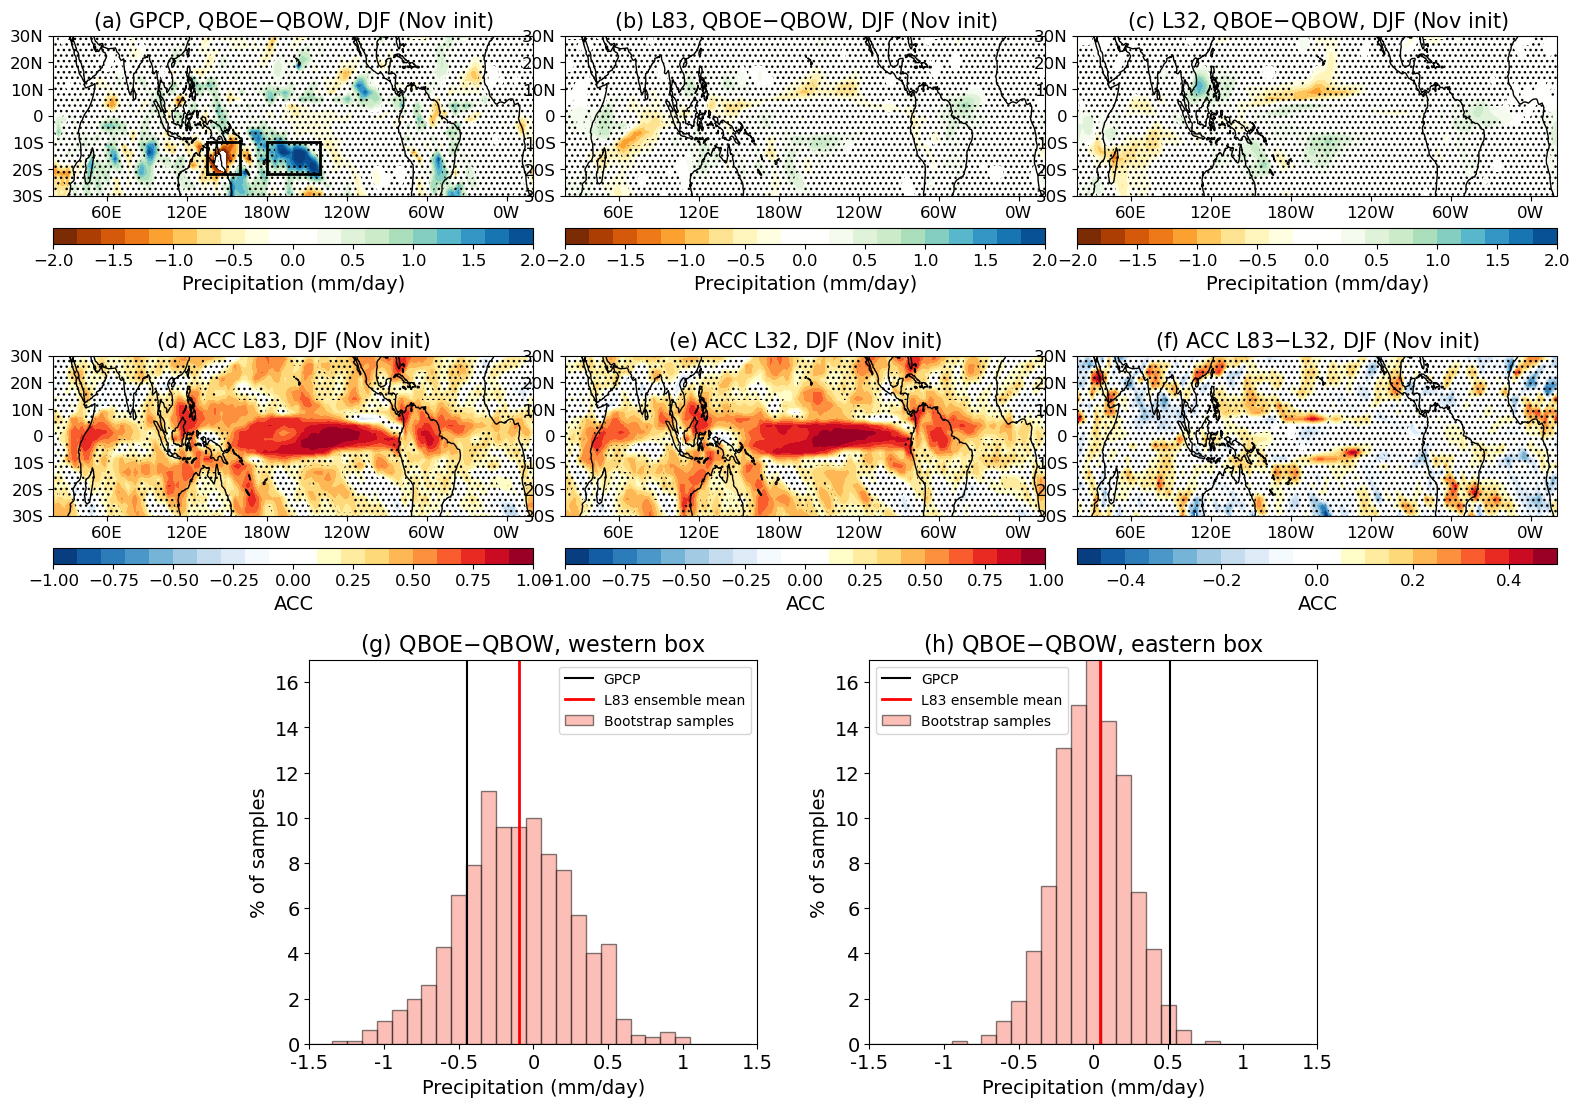

In [38]:
fig = plt.figure(figsize=(16,16))

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, east_gpcp_noenso.mean('init_year') - west_gpcp_noenso.mean('init_year'), gpcp.lon, gpcp.lat, 0.2,-2,2,
                                                   '(a) GPCP, QBOE$-$QBOW, DJF (Nov init)',
                                                   0.02,0.32,0.8,0.9, cmap='precip', signifdat = gpcp_difsignif_noenso, stipplesignif=True)
ax.plot([135,135],[-22,-10], transform=ccrs.PlateCarree(), color='black', linewidth=2)
ax.plot([160,160],[-22,-10], transform=ccrs.PlateCarree(), color='black', linewidth=2)
ax.plot([135,160],[-22,-22], transform=ccrs.PlateCarree(), color='black', linewidth=2)
ax.plot([135,160],[-10,-10], transform=ccrs.PlateCarree(), color='black', linewidth=2)


ax.plot([180,180],[-22,-10], transform=ccrs.PlateCarree(), color='black', linewidth=2)
ax.plot([220,220],[-22,-10], transform=ccrs.PlateCarree(), color='black', linewidth=2)
ax.plot([180,220],[-22,-22], transform=ccrs.PlateCarree(), color='black', linewidth=2)
ax.plot([180,220],[-10,-10], transform=ccrs.PlateCarree(), color='black', linewidth=2)

ax = cbars.plotcolorbar(fig, 0.2, -2, 2, 'Precipitation (mm/day)', 0.02,0.32,0.77,0.78,cmap='precip', fsize=12)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, east_l83_noenso.mean(['init_year','M']) - west_l83_noenso.mean(['init_year','M']), east_l83_noenso.lon, east_l83_noenso.lat, 0.2,-2,2,
                                                   '(b) L83, QBOE$-$QBOW, DJF (Nov init)',
                                                   0.34,0.64,0.8,0.9,cmap='precip', signifdat = l83_difsignif_noenso, stipplesignif=True, ylabel=False)


ax = cbars.plotcolorbar(fig, 0.2, -2, 2, 'Precipitation (mm/day)', 0.34,0.64,0.77,0.78,cmap='precip', fsize=12)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, east_l32_noenso.mean(['init_year','M']) - west_l32_noenso.mean(['init_year','M']), east_l32_noenso.lon, east_l32_noenso.lat, 0.2,-2,2,
                                                   '(c) L32, QBOE$-$QBOW, DJF (Nov init)',
                                                   0.66,0.96,0.8,0.9,cmap='precip', signifdat = l32_difsignif_noenso, stipplesignif=True, ylabel=False)

ax = cbars.plotcolorbar(fig, 0.2, -2, 2, 'Precipitation (mm/day)', 0.66,0.96,0.77,0.78,cmap='precip', fsize=12)


signifplot = signifdat.min95_l83_cor * nan
signifplot = signifplot.where( ~(( signifdat.min95_l83_cor < 0) & (signifdat.max95_l83_cor > 0)), 1)
ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, cor_l83, cor_l83.lon, cor_l83.lat, 0.1, -1, 1, 
                                                   '(d) ACC L83, DJF (Nov init)',
                                               0.02,0.32,0.6,0.7, signifdat = signifplot, stipplesignif=True, ylabel=False)

ax = cbars.plotcolorbar(fig, 0.1, -1, 1, 'ACC', 0.02,0.32,0.57,0.58, fsize=12)


signifplot = signifdat.min95_l32_cor * nan
signifplot = signifplot.where( ~((signifdat.min95_l32_cor < 0) & (signifdat.max95_l32_cor > 0)), 1)
ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, cor_l32, cor_l32.lon, cor_l32.lat, 0.1, -1, 1, 
                                                   '(e) ACC L32, DJF (Nov init)',
                                               0.34,0.64,0.6,0.7, signifdat = signifplot, stipplesignif=True)

ax = cbars.plotcolorbar(fig, 0.1, -1, 1, 'ACC', 0.34,0.64,0.57,0.58, fsize=12)

signifplot = signifdat.min95_dif_cor * nan
signifplot = signifplot.where( ~(( signifdat.min95_dif_cor < 0) & (signifdat.max95_dif_cor > 0)), 1)
ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, (cor_l83 - cor_l32), cor_l83.lon, cor_l83.lat, 0.05, -0.5, 0.5, 
                                                   '(f) ACC L83$-$L32, DJF (Nov init)',
                                               0.66,0.96,0.6,0.7, signifdat = signifplot, stipplesignif=True, ylabel=False)

ax = cbars.plotcolorbar(fig, 0.05,-0.5,0.5,'ACC',0.66,0.96,0.57,0.58,fsize=12)


ax = histo.plothisto(fig,pr_qbo_dif_l83_boot_westbox , np.arange(-1.5,1.6,0.1),0.18,0.46,0.27,0.51,percent=True, label='Bootstrap samples', color='salmon', alpha=0.5)
ax.plot([pr_qbo_dif_gpcp_westbox, pr_qbo_dif_gpcp_westbox], [0,17], color='black', label='GPCP')
ax.plot([pr_qbo_dif_l83_westbox.mean('M'), pr_qbo_dif_l83_westbox.mean('M')],[0,17], color='red', linewidth=2, label='L83 ensemble mean')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(0,17)
ax.set_yticks([0,2,4,6,8,10,12,14,16])
ax.set_yticklabels(['0','2','4','6','8','10','12','14','16'], fontsize=14)
ax.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5])
ax.set_xticklabels(['-1.5','-1','-0.5','0','0.5','1','1.5'], fontsize=14)
ax.set_title('(g) QBOE$-$QBOW, western box', fontsize=16)
ax.set_xlabel('Precipitation (mm/day)', fontsize=14)
ax.set_ylabel('% of samples', fontsize=14)
ax.legend()

ax = histo.plothisto(fig, pr_qbo_dif_l83_boot_eastbox, np.arange(-1.5,1.6,0.1), 0.53,0.81, 0.27, 0.51, percent=True, label='Bootstrap samples', color='salmon', alpha=0.5)
ax.plot([pr_qbo_dif_gpcp_eastbox, pr_qbo_dif_gpcp_eastbox], [0,17], color='black', label='GPCP')
ax.plot([pr_qbo_dif_l83_eastbox.mean('M'), pr_qbo_dif_l83_eastbox.mean('M')],[0,17], color='red', linewidth=2, label='L83 ensemble mean')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(0,17)
ax.set_yticks([0,2,4,6,8,10,12,14,16])
ax.set_yticklabels(['0','2','4','6','8','10','12','14','16'], fontsize=14)
ax.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5])
ax.set_xticklabels(['-1.5','-1','-0.5','0','0.5','1','1.5'], fontsize=14)
ax.set_title('(h) QBOE$-$QBOW, eastern box', fontsize=16)
ax.set_xlabel('Precipitation (mm/day)', fontsize=14)
ax.set_ylabel('% of samples', fontsize=14)
ax.legend()


fig.savefig(plotpath+'fig14.png', bbox_inches='tight', facecolor='white')